In [1]:
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers
import numpy as np
import os

2024-05-29 03:18:44.778407: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-29 03:18:44.778521: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-29 03:18:44.947296: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# !cp -r "/kaggle/input/new-dataset/new_dataset" "new_dataset"

!mkdir "dataset"
!cp -r "/kaggle/input/dataset-paling-new/input/combined_dataset" "dataset/blur"
!cp -r "/kaggle/input/dataset-paling-new/input/combined_dataset_bokeh" "dataset/bokeh"

In [3]:
dataset = "/kaggle/working/dataset"
image_size = (225, 225)
input_shape = list(image_size) + [3]
batch_size = 32
class_names = tuple(os.listdir(dataset))

In [4]:
# train 70 val 15 test 15

train_ds, val_ds = keras.utils.image_dataset_from_directory(dataset, 
                                                        image_size=image_size, 
                                                        seed=42,
                                                       validation_split=0.3,
                                                       subset='both',
                                                        label_mode='binary',
                                                            batch_size=None
                                                       )

test_ds = val_ds.take(len(list(val_ds))//2)
val_ds = val_ds.skip(len(list(val_ds))//2)

print(len(list(train_ds)), len(list(val_ds)), len(list(test_ds)))

train_ds = train_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Found 3402 files belonging to 2 classes.
Using 2382 files for training.
Using 1020 files for validation.
2382 510 510


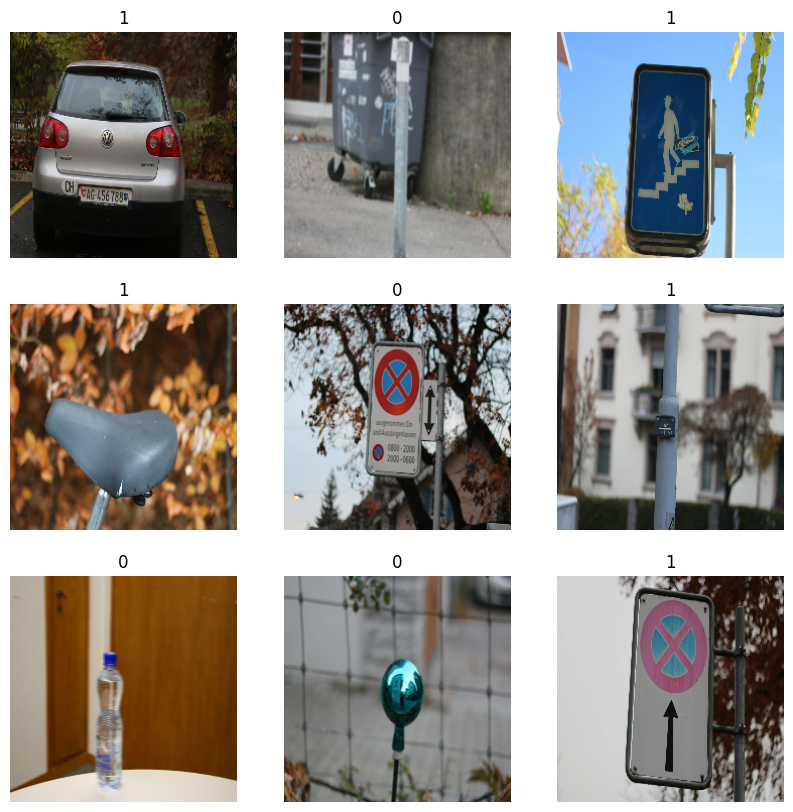

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Data Augmentation

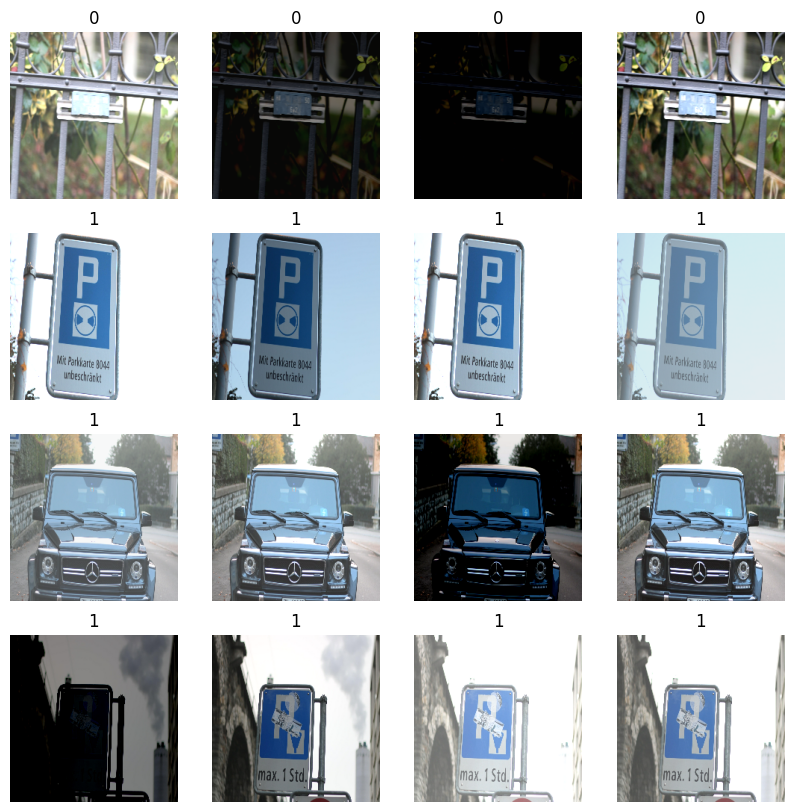

In [6]:
layer_aug = tf.keras.Sequential([
    layers.RandomBrightness(0.5),
    layers.RandomContrast(0.5)
])

plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(16):
        plt.subplot(4, 4, i+1)
        aug = np.array(layer_aug(images[i//4]))
        plt.imshow(aug.astype('uint8'))
        plt.title(int(labels[i//4]))
        plt.axis('off')

In [7]:
augmented_ds = train_ds.unbatch().map(lambda x, y : (layer_aug(x), y)).batch(batch_size)
augmented_ds = train_ds.concatenate(augmented_ds)

augmented_ds = augmented_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

## Prepare Dataset

In [8]:
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

## Build Model

In [9]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same", activation='relu')(x)

    for size in [256, 512, 728]:
        x = layers.Conv2D(size, 3, padding="same", activation="relu")(x)
        x = layers.Conv2D(size, 3, padding="same", activation="relu")(x)
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        x = layers.Conv2D(size, 1, strides=2, padding="same")(
            x
        )

    x = layers.Conv2D(1024, 3, padding="same", activation='relu')(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=input_shape, num_classes=2)
# keras.utils.plot_model(model, show_shapes=True)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 225, 225, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 225, 225, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 113, 113, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 113, 113, 256)  │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 113, 113, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 57, 57, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 29, 29, 256)    │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 29, 29, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 29, 29, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 15, 15, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 512)      │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 728)      │     3,355,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 728)      │     4,770,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 728)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 2, 2, 728)      │       530,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 2, 2, 1024)     │     6,710,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2, 2, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,129,289 (76.79 MB)

 Trainable params: 20,127,241 (76.78 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [10]:
epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint("model.keras",
                                   save_best_only=True,
                                   verbose=1,
                                   monitor='val_accuracy',
                                   mode='max'),
]
model.compile(
    optimizer="adam",
    loss='binary_crossentropy',
    metrics=["accuracy"],
)
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
    verbose=1
)

Epoch 1/20


I0000 00:00:1716952893.486854      98 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5095 - loss: 0.7796   

2024-05-29 03:23:13.856635: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng36{k2=3,k3=0} for conv (f32[30,256,113,113]{3,2,1,0}, u8[0]{0}) custom-call(f32[30,256,113,113]{3,2,1,0}, f32[256,256,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-05-29 03:23:13.938665: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.082150963s
Trying algorithm eng36{k2=3,k3=0} for conv (f32[30,256,113,113]{3,2,1,0}, u8[0]{0}) custom-call(f32[30,256,113,113]{3,2,1,0}, f32[256,256,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_al


Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to model.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step - accuracy: 0.5094 - loss: 0.7789 - val_accuracy: 0.5000 - val_loss: 1.0220
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.5217 - loss: 0.6959
Epoch 2: val_accuracy did not improve from 0.50000
75/75 ━━━━━━━━━━━━━━━━━━━━ 33s 390ms/step - accuracy: 0.5214 - loss: 0.6959 - val_accuracy: 0.5000 - val_loss: 0.8273
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.5055 - loss: 0.6945
Epoch 3: val_accuracy improved from 0.50000 to 0.50196, saving model to model.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 42s 409ms/step - accuracy: 0.5063 - loss: 0.6942 - val_accuracy: 0.5020 - val_loss: 1.4062
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.8203 - loss: 0.4201
Epoch 4: val_accuracy improved from 0.50196 to 0.89608, saving model to model.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 33s 403ms/step - accuracy: 0.8206 - loss: 0.4197 - val_accurac

Text(0.5, 1.0, 'Loss')

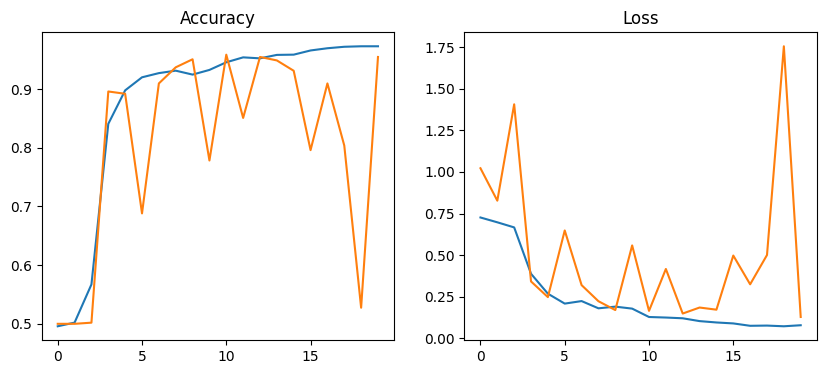

In [11]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy")

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss")

In [12]:
model_2 = keras.models.load_model("model.keras")

In [13]:
test_images = []
test_labels = []

for images, labels in test_ds.unbatch():
    test_images.append(images)
    test_labels.append(labels)
    
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [14]:
from sklearn.metrics import classification_report

predictions = np.array(tf.greater(model_2.predict(test_images), .5))
predictions = np.reshape(predictions, predictions.shape[0])
predictions = predictions.astype('int')

print(classification_report(predictions, test_labels))

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       235
           1       0.99      0.89      0.93       275

    accuracy                           0.93       510
   macro avg       0.93      0.94      0.93       510
weighted avg       0.94      0.93      0.93       510



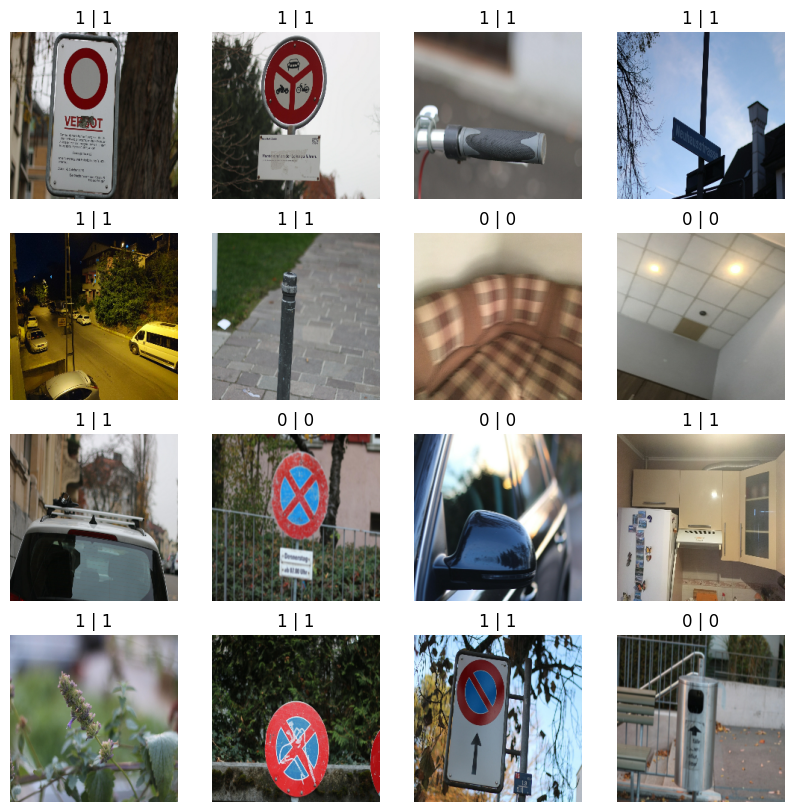

In [15]:
plt.figure(figsize=(10,10))

for images, labels in test_ds.take(1):
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.array(images[i]).astype('uint8'))
        plt.title(f"{int(labels[i])} | {predictions[i]}")
        plt.axis('off')